In [1]:
%tensorflow_version 1.x

import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [3]:
!pip install q keras==2.1.5

  Using cached https://files.pythonhosted.org/packages/ba/65/e4aff762b8696ec0626a6654b1e73b396fcc8b7cc6b98d78a1bc53b85b48/Keras-2.1.5-py2.py3-none-any.whl
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [5]:
!git clone --quiet https://github.com/matterport/Mask_RCNN.git

In [6]:
%cd Mask_RCNN/

!pip install -q PyDrive
!pip install -r requirements.txt
!python setup.py install

/content/Mask_RCNN
     |████████████████████████████████| 204kB 7.6MB/s 
     |████████████████████████████████| 163kB 13.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=08b032bef23373c1b6a8e367d19f74e18202c4b4f467afe2a7c73dec7fedf022
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/m

In [7]:
import os
import sys
import random
import math
import re
import time
import datetime
import numpy as np
import cv2
import json
import skimage.draw

from tqdm import tqdm
from os import listdir
from os.path import isfile, join

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
# Results directory
# Save submission files here
RESULTS_DIR = os.path.join(ROOT_DIR, "results/cats_and_dogs/")

Using TensorFlow backend.


... done downloading pretrained model!


In [8]:
### colab
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')
IMAGE_DIR = os.path.join(ROOT_DIR, "/content/gdrive/My Drive/workspace/images")
print(IMAGE_DIR)

Mounted at /content/gdrive
/content/gdrive/My Drive/workspace/images


In [9]:
############################################################
#  Configurations
############################################################

class CustomConfig(Config):
    """Configuration for training on the toy  dataset.
        Derives from the base Config class and overrides some values.
        """
    # Give the configuration a recognizable name
    NAME = "CatsAndDogs"
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 2 # Background + (cat + dog)
    
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 5
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

class CustomInferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9


In [10]:
############################################################
#  Dataset
############################################################

class CustomDataset(utils.Dataset):
    
    def load_custom_data(self, dataset_dir, subset):
        """ Load a subset of the dataset.
            dataset_dir: Root directory of the dataset.
            subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        source_name = "CatsAndDogs"
        classes = ["cat", "dog"]
        for i in range(len(classes)):
            self.add_class(source_name, i+1, classes[i])
        
        # Train or validation dataset
        assert subset in ["train", "val", "test"]
        image_dir = os.path.join(dataset_dir, subset)
        
        # load annotation
        dataset_json = [f for f in listdir(image_dir) if f.endswith(".json")]
        
        for item in tqdm(dataset_json):
            raw = json.load(open(os.path.join(image_dir, item)))
            if type(raw) is list:
                if 0 < len(raw):
                    annotation = raw[0]
                else:
                    continue
        
            if annotation['geometry']['type'] != 'Polygon':
                continue
            
            if type(annotation['geometry']['coordinates']) is not list:
                print("Error:", annotation)
                continue
            
            all_point_x = []
            all_point_y = []
            for a in annotation['geometry']['coordinates'][0]:
                all_point_x.append(int(a[0]))
                all_point_y.append(int(a[1]))
            
            polygons = {}
            polygons["all_points_x"] = all_point_x
            polygons["all_points_y"] = all_point_y
            kind = annotation["properties"]["classification"]["name"]
            # validation
            if not kind in classes:
                continue

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must
            # read the image. This is only managable since the dataset is
            # tiny.
            image_file = os.path.splitext(item)[0] + '.jpg'
            image_path = os.path.join(image_dir, image_file)
            if False == os.path.exists(image_path):
                continue
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            
            # use file name as a unique image id
            self.add_image(source_name,
                           image_id=image_file,
                           path=image_path,
                           width=width, height=height,
                           polygons=polygons, type=kind)


    def load_mask(self, image_id):
        """Generate instance masks for an image.
            Returns:
            masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
            """
        # If not a custom dataset image, delegate to parent class.
        info = self.image_info[image_id]
        if info["source"] != "CatsAndDogs":
            return super(self.__class__, self).load_mask(image_id)
                
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        # If instance_count was more than one, change that parameter
        mask = np.zeros([info["height"], info["width"], 1],
                        dtype=np.uint8)

        rr, cc = skimage.draw.polygon(info['polygons']['all_points_y'],
                                        info['polygons']['all_points_x'])
        mask[rr, cc, 0] = 1

        class_ids = np.array([self.class_names.index(info["type"])])

        return mask.astype(np.bool), class_ids.astype(np.int32)


    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "CatsAndDogs":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [11]:
# Training dataset.
dataset_train = CustomDataset()
dataset_train.load_custom_data(IMAGE_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom_data(IMAGE_DIR, "val")
dataset_val.prepare()

100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


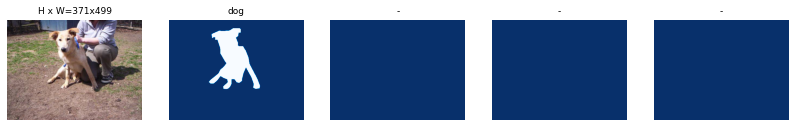

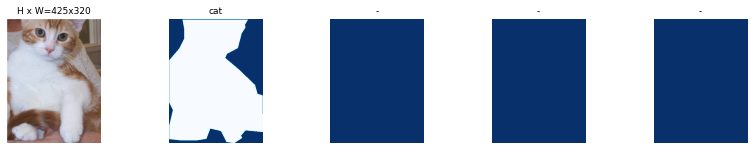

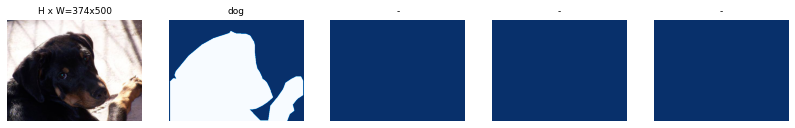

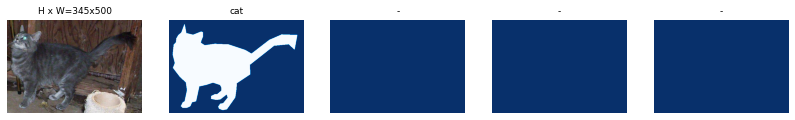

In [12]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [13]:
# train
config = CustomConfig()
config.display()
model = modellib.MaskRCNN(mode="training", config=config, 
                          model_dir=DEFAULT_LOGS_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=2,
            layers='all')


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/2
 99/100 [============================>.] - ETA: 1s - loss: 1.1783 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.2691 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.4404 - mrcnn_mask_loss: 0.3802

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 160s 2s/step - loss: 1.1720 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.2685 - mrcnn_class_loss: 0.0838 - mrcnn_bbox_loss: 0.4368 - mrcnn_mask_loss: 0.3784 - val_loss: 0.8525 - val_rpn_class_loss: 0.0094 - val_rpn_bbox_loss: 0.3067 - val_mrcnn_class_loss: 0.0458 - val_mrcnn_bbox_loss: 0.2271 - val_mrcnn_mask_loss: 0.2635

Epoch 2/2
100/100 [==============================] - 88s 877ms/step - loss: 0.6427 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.2162 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.2130 - mrcnn_mask_loss: 0.1668 - val_loss: 1.0437 - val_rpn_class_loss: 0.0029 - val_rpn_bbox_loss: 0.4281 - val_mrcnn_class_loss: 0.0591 - val_mrcnn_bbox_loss: 0.2843 - val_mrcnn_mask_loss: 0.2694


In [14]:
# copy model in my drive(optional)
RES_MODEL = model.find_last()
!cp {RES_MODEL} /content/gdrive/My\ Drive/workspace


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

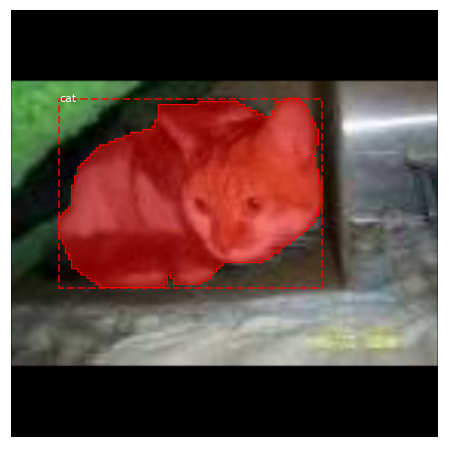

In [16]:
# detection
config = CustomInferenceConfig()
config.display()
model = modellib.MaskRCNN(mode="inference", config=config,
                          model_dir=DEFAULT_LOGS_DIR)

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
  model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
  # Load weights trained on MS COCO, but skip layers that
  # are different due to the different number of classes
  # See README for instructions to download the COCO weights
  model.load_weights(COCO_MODEL_PATH, by_name=True,
                      exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                              "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
  # Load the last model you trained and continue training
  model.load_weights(model.find_last(), by_name=True)

# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
  modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)

print("image id:", image_id)
print("gt_class_id:", gt_class_id)
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))